# 빅데이터 분석 결과 시각화 - 신예원

## 1) 문항1
### OpenAPI로부터 데이터 수집

In [1]:
import requests
import json
import datetime as dt
import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot
from bs4 import BeautifulSoup

In [2]:
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.190 Safari/537.36"
session= requests.Session()
session.headers.update({'User-agent':user_agent, 'referer':None})

api_url = "http://itpaper.co.kr/demo/covid19/all.php"

# 데이터 가져오기
r = session.get(api_url)

# 결과 검사
if r.status_code != 200:
    print("[%d Error] %s" % (r.status_code, r.reason))
    quit()
    
r.encoding = 'utf-8'
covid19_dict = json.loads(r.text)

#covid19_dict

### 데이터 전처리 및 데이터프레임 재구성

In [3]:
지역명 = list(covid19_dict['data'].keys())

데이터누적 = DataFrame()

for v in 지역명:
    # 하나의 지역을 임시 데이터프레임으로 변환
    tmp_df = DataFrame(covid19_dict['data'][v])
    
    # 임시 데이터 프레임에 지역명 컬럼 추가
    tmp_df['지역'] = v
    
    # 임시 데이터 프레임을 누적해서 병합
    데이터누적 = 데이터누적.append(tmp_df)
    
# 컬럼이름 변경을 위한 딕셔너리 정의
column_name = {'date':'날짜', 'active':'치료중', 'confirmed_acc':'누적확진자', 'death_acc':'누적사망자', 'released_acc':'누적격리해제',
              'confirmed':'확진자', 'death':'사망자', 'released':'격리해제'}
데이터누적.rename(columns=column_name, inplace=True)

# 데이터 병합과정에서 중복되는 index가 발생하므로 index 번호를 리셋한다
# -> drop=True는 기존의 인덱스를 삭제하는 옵션
데이터누적.reset_index(drop=True, inplace=True)

데이터누적

,날짜,치료중,누적확진자,누적사망자,누적격리해제,확진자,사망자,격리해제,지역
0,20200217,11,14,0,3,14,0,3,서울
1,20200218,11,14,0,3,0,0,0,서울
2,20200219,10,15,0,5,1,0,2,서울
3,20200220,17,22,0,5,7,0,0,서울
4,20200221,21,27,0,6,5,0,1,서울
...,...,...,...,...,...,...,...,...,...
6506,20210301,26,570,1,543,0,0,5,제주
6507,20210302,29,575,1,545,5,0,2,제주
6508,20210303,33,579,1,545,4,0,0,제주
6509,20210304,34,582,1,547,3,0,2,제주


### 날짜타입을 datetime 형식으로 변환 처리

In [4]:
covid19_df = 데이터누적.copy()
# infer_datetime_format=True는 파이썬이 문자열의 날짜형식을 지능적으로 판단하여 format 추측
covid19_df['날짜'] = pd.to_datetime(covid19_df['날짜'], infer_datetime_format=True)
covid19_df['날짜']

0      2020-02-17
1      2020-02-18
2      2020-02-19
3      2020-02-20
4      2020-02-21
          ...    
6506   2021-03-01
6507   2021-03-02
6508   2021-03-03
6509   2021-03-04
6510   2021-03-05
Name: 날짜, Length: 6511, dtype: datetime64[ns]

## 2) 문항2 - 오늘까지의 전국 누적 확진자 현황 파악

In [12]:
# 가장 큰 날짜값 추출(오늘)
last_date = covid19_df['날짜'].max()

# 마지막 날짜에 해당하는 데이터만 추출 (지역별로 출력)
last_df = covid19_df.query('날짜 == @last_date')

# 각 컬럼별 총 합계 계산
전국합계 = last_df.sum()
#전국합계

# 데이터프레임으로 병합
전국합계df = DataFrame(전국합계, columns=[last_date.strftime('%Y-%m-%d')])
전국합계df.drop('지역', inplace=True)
전국합계df.T

,치료중,누적확진자,누적사망자,누적격리해제,확진자,사망자,격리해제
2021-03-05,6777,88642,1623,80242,394,8,397


## 3) 문항 3 - 최근 일주일 간 확진자 현황 파악

In [13]:
# 날짜별 전국 합산 계산
날짜별df = covid19_df.filter(['날짜', '치료중', '누적확진자', 
                           '누적사망자', '누적격리해제', '확진자', '사망자', '격리해제']).groupby('날짜').sum()


# 일주일 전 날짜 얻기
delta = dt.timedelta(days=-7)
day7 = dt.datetime.now()+delta
#day7

# 일주일 전 날짜 이후의 데이터 조회
일주일검색df = 날짜별df[(날짜별df.index>=day7)]
일주일검색df

,치료중,누적확진자,누적사망자,누적격리해제,확진자,사망자,격리해제
날짜,,,,,,,
2021-02-27,6747,86357,1592,78018,412,10,415
2021-02-28,6722,86703,1599,78382,346,7,364
2021-03-01,6697,87053,1601,78755,350,2,373
2021-03-02,6763,87388,1602,79023,335,1,268
2021-03-03,6837,87830,1608,79385,442,6,362
2021-03-04,6788,88248,1615,79845,418,7,460
2021-03-05,6777,88642,1623,80242,394,8,397


## 4) 문항 4 - 최근 일주일 간 일별 확진자 추세 + 누적 확진자 현황 시각화

In [15]:
# 그래프를 만들기 위한 한글 폰트 설정
pyplot.rcParams['font.family'] = 'Malgun Gothic'
pyplot.rcParams['font.size'] = 16
pyplot.rcParams['figure.figsize'] = (20, 10)

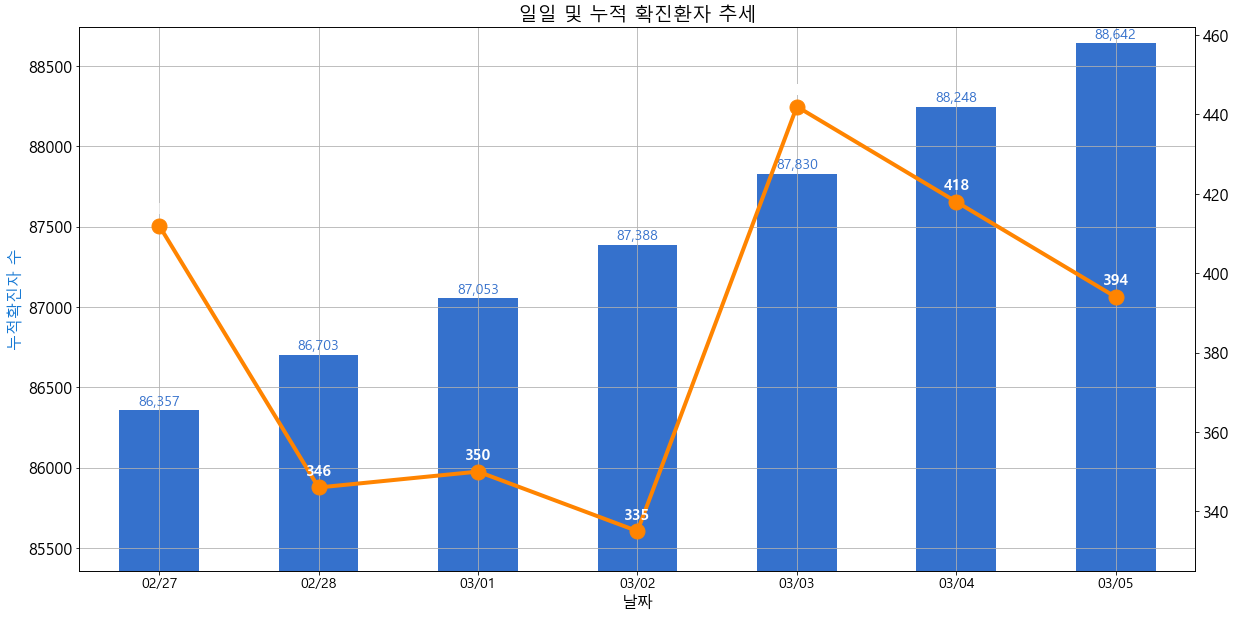

In [17]:
fig = pyplot.figure()       # 그래프 시작
ax1=fig.add_subplot(1,1,1)  # 1행 1열로 구성된 서브플롯 생성
ax2=ax1.twinx()             # ax1에 겹쳐지는 서브플롯 생성

pyplot.title('일일 및 누적 확진환자 추세')


#----------------------------------------------------
# 누적 확진 (막대 그래프)
#----------------------------------------------------
일주일검색df['누적확진자'].plot.bar(ax=ax1, color='#3571cc', rot=0)

ax1.set_xlabel('날짜')
ax1.set_ylabel('누적확진자 수', color='#1779d4')
ax1.grid()
ax1.set_ylim([일주일검색df['누적확진자'].min()-1000, 일주일검색df['누적확진자'].max()+100])

# 그래프 위에 텍스트 표시
for i, v in enumerate(일주일검색df['누적확진자']):
    # 세자리마다 콤마를 표시하는 형식 지정
    msg = '{n:,}'.format(n=v)
    ax1.text(i, v+10, msg, fontsize=14, color="#3571cc",
            horizontalalignment='center', verticalalignment='bottom')
    
# x축 표시 라벨 설정
k = list(range(0, len(일주일검색df)))
ax1.set_xticks(k)

# x축 라벨에 표시할 텍스트
x_labels=[]

for date in 일주일검색df.index:
    x_labels.append(date.strftime("%m/%d"))

ax1.set_xticklabels(x_labels, fontsize=14, color='#000000')

#----------------------------------------------------
# 일별 확진 (시계열 그래프)
#----------------------------------------------------
x = list(range(0, len(일주일검색df)))
y = 일주일검색df['확진자']
ax2.plot(x, y, color='#ff8400', marker='o', linewidth=4, markersize=15)

ax2.set_ylim([일주일검색df['확진자'].min()-10, 일주일검색df['확진자'].max()+20])

# 시계열 그래프 위에 텍스트 표시
for i, v in enumerate(일주일검색df['확진자']):
    # 세자리마다 콤마를 표시하는 형식 지정
    msg = '{n:,}'.format(n=v)
    ax2.text(i, v+2, msg, fontsize=15, color="#ffffff",
            horizontalalignment='center', verticalalignment='bottom', fontweight='bold')
    
pyplot.show()

## 5) 문항 5 - 최근 일주일 간 일일 및 누적 격리 해제 현황 시각화

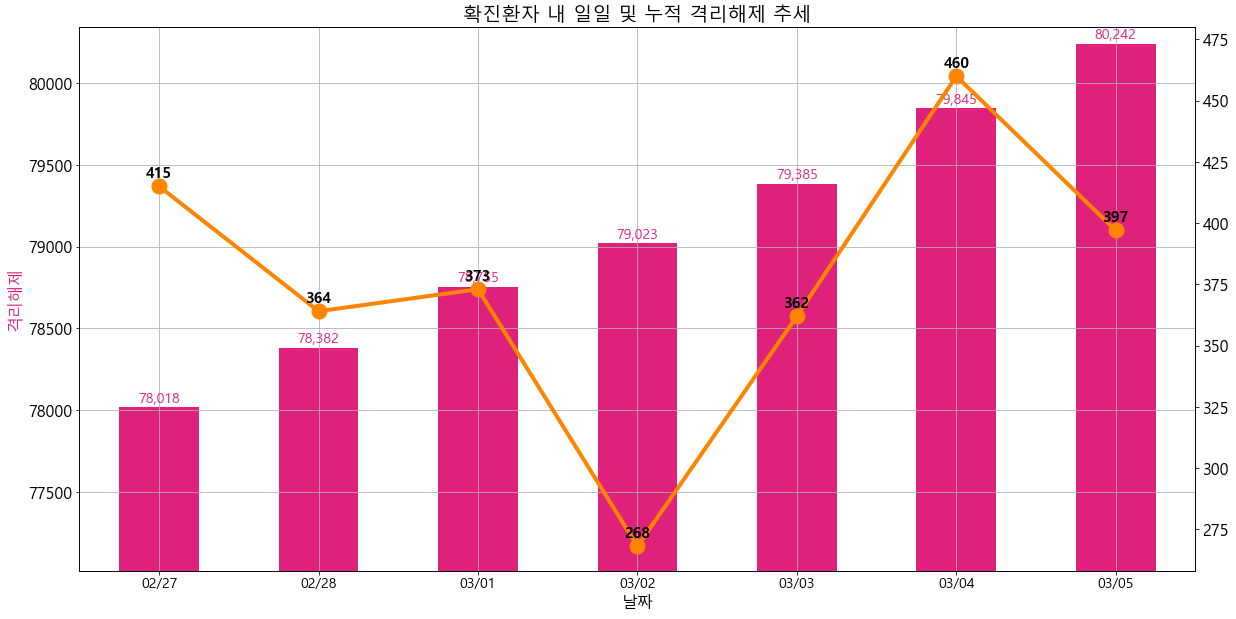

In [19]:
fig = pyplot.figure()       # 그래프 시작
ax1=fig.add_subplot(1,1,1)  # 1행 1열로 구성된 서브플롯 생성
ax2=ax1.twinx()             # ax1에 겹쳐지는 서브플롯 생성

pyplot.title('확진환자 내 일일 및 누적 격리해제 추세')


#----------------------------------------------------
# 누적 확진 (막대 그래프)
#----------------------------------------------------
일주일검색df['누적격리해제'].plot.bar(ax=ax1, color='#E0217B', rot=0)

ax1.set_xlabel('날짜')
ax1.set_ylabel('격리해제', color='#E0217B')
ax1.grid()
ax1.set_ylim([일주일검색df['누적격리해제'].min()-1000, 일주일검색df['누적격리해제'].max()+100])

# 그래프 위에 텍스트 표시
for i, v in enumerate(일주일검색df['누적격리해제']):
    # 세자리마다 콤마를 표시하는 형식 지정
    msg = '{n:,}'.format(n=v)
    ax1.text(i, v+10, msg, fontsize=14, color="#E0217B",
            horizontalalignment='center', verticalalignment='bottom')
    
# x축 표시 라벨 설정
k = list(range(0, len(일주일검색df)))
ax1.set_xticks(k)

# x축 라벨에 표시할 텍스트
x_labels=[]

for date in 일주일검색df.index:
    x_labels.append(date.strftime("%m/%d"))

ax1.set_xticklabels(x_labels, fontsize=14, color='#000000')

#----------------------------------------------------
# 일별 확진 (시계열 그래프)
#----------------------------------------------------
x = list(range(0, len(일주일검색df)))
y = 일주일검색df['격리해제']
ax2.plot(x, y, color='#ff8400', marker='o', linewidth=4, markersize=15)

ax2.set_ylim([일주일검색df['격리해제'].min()-10, 일주일검색df['격리해제'].max()+20])

# 시계열 그래프 위에 텍스트 표시
for i, v in enumerate(일주일검색df['격리해제']):
    # 세자리마다 콤마를 표시하는 형식 지정
    msg = '{n:,}'.format(n=v)
    ax2.text(i, v+2, msg, fontsize=15, color="#000000",
            horizontalalignment='center', verticalalignment='bottom', fontweight='bold')
    
pyplot.show()